In [1]:
from init.cons import Config
import matlab.engine
import matlab
import time
import numpy as np
import os
import glob
from CONSTANTS.constants import constants
import CONSTANTS.conditions as conditions
import init.load_matlab

import Fabio.decoding as dc
import Fabio.plots as pt
import Fabio.utils as ut
import matplotlib.pyplot as plt

In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

In [3]:
def decode(config, data, chosen_odors, csp_odors, arg ='valence'):
    def _assign_labels(list_of_masks):
        decode_labels = np.zeros_like(list_of_masks[0]).astype(int)
        for i, mask in enumerate(list_of_masks):
            decode_labels[mask] = i+1
        return decode_labels

    nF = config.TRIAL_FRAMES
    data_cell_trial_time = data.reshape(data.shape[0], data.shape[1] // nF, nF)
    data_trial_cell_time = np.transpose(data_cell_trial_time, (1, 0, 2))
    names = config.ODOR_UNIQUE
    labels = config.ODOR_TRIALIDX

    us = {'water'}
    csm = list(set(chosen_odors) - set(csp_odors) - set(us))
    f = lambda x: np.argwhere(np.isin(names, x)).flatten()
    csp1_ix, csp2_ix, csm1_ix, csm2_ix = f(csp_odors[0]), f(csp_odors[1]), f(csm[0]), f(csm[1])
    water_ix = f(us)

    if arg == 'valence':
        csp_mask = np.isin(labels, [csp1_ix, csp2_ix])
        csm_mask = np.isin(labels, [csm1_ix, csm2_ix])
        list_of_masks = [csp_mask, csm_mask]
    elif arg == 'identity':
        ixs = [csp1_ix, csp2_ix, csm1_ix, csm2_ix]
        list_of_masks = []
        for ix in ixs:
            mask = np.isin(labels, ix)
            list_of_masks.append(mask)
    elif arg == 'csp_identity':
        ixs = [csp1_ix, csp2_ix]
        list_of_masks = []
        for ix in ixs:
            mask = np.isin(labels, ix)
            list_of_masks.append(mask)
    elif arg == 'csm_identity':
        ixs = [csm1_ix, csm2_ix]
        list_of_masks = []
        for ix in ixs:
            mask = np.isin(labels, ix)
            list_of_masks.append(mask)
    else:
        raise ValueError('Unknown decoding type {:s}'.format(arg))

    good_trials = np.any(list_of_masks, axis=0)
    decode_labels = _assign_labels(list_of_masks)
    scores = dc.decode_odors_time_bin(data_trial_cell_time, decode_labels, good_trials=good_trials, cv=10)
    return scores

In [4]:
condition = conditions.OFC
condition_name = condition.condition
decode_style = 'csm_identity'
path = r'C:\Users\Peter\PycharmProjects\phd_project\DATA\timepoint\OFC'
mouse_files = [os.path.join(path, o) for o in os.listdir(path)
                    if os.path.isdir(os.path.join(path,o))]

all_decode_data = []
for i, (mouse_file, odors, csps) in enumerate(zip(mouse_files, condition.odors, condition.csp)):
    pickle_files = [os.path.join(mouse_file, o) for o in os.listdir(mouse_file)]
    mouse_decode_data = []
    for j, pickle_file in enumerate(pickle_files):
        config, data = init.load_matlab.load_pickle(pickle_file)
        scores = decode(config, data, odors, csps, arg=decode_style)
        mouse_decode_data.append((scores, config))
    all_decode_data.append(mouse_decode_data)

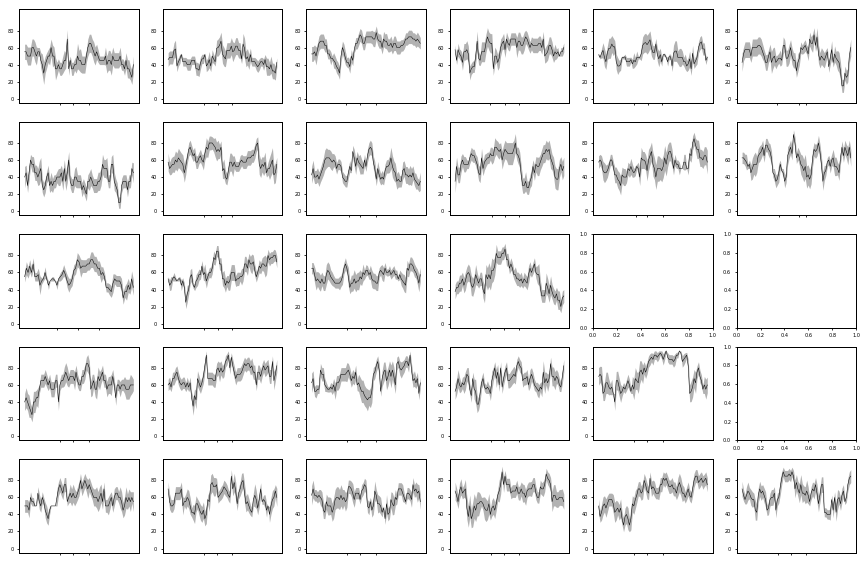

In [5]:
r, c = (len(condition.paths), 6)
f, axs = plt.subplots(r,c)
f.set_size_inches(15,10)
ylim = [-5, 105]
yticks = np.arange(0,100,20)
for i, mouse_decode_data in enumerate(all_decode_data):
    for j, (score, config) in enumerate(mouse_decode_data):
        time = np.arange(0, config.TRIAL_FRAMES) * config.TRIAL_PERIOD - config.DAQ_O_ON
        xticks = np.asarray([config.DAQ_O_ON, config.DAQ_O_OFF, config.DAQ_W_ON]) - config.DAQ_O_ON
        xticks = np.round(xticks, 1)
        pt.plot_decoding_performance(time, score, ax=axs[i,j], add_labels=False)
        axs[i,j].set_ylim(ylim)
        axs[i,j].set_yticks(yticks)
        axs[i,j].set_xticks(xticks)
        axs[i,j].set_xticklabels(['','',''])
plt.show()

In [6]:
condition = conditions.OFC
condition_name = condition.condition
decode_style = 'valence'
path = r'C:\Users\Peter\PycharmProjects\phd_project\DATA\timepoint\OFC'
mouse_files = [os.path.join(path, o) for o in os.listdir(path)
                    if os.path.isdir(os.path.join(path,o))]

all_decode_data = []
for i, (mouse_file, odors, csps) in enumerate(zip(mouse_files, condition.odors, condition.csp)):
    pickle_files = [os.path.join(mouse_file, o) for o in os.listdir(mouse_file)]
    mouse_decode_data = []
    for j, pickle_file in enumerate(pickle_files):
        config, data = init.load_matlab.load_pickle(pickle_file)
        scores = decode(config, data, odors, csps, arg=decode_style)
        mouse_decode_data.append((scores, config))
    all_decode_data.append(mouse_decode_data)

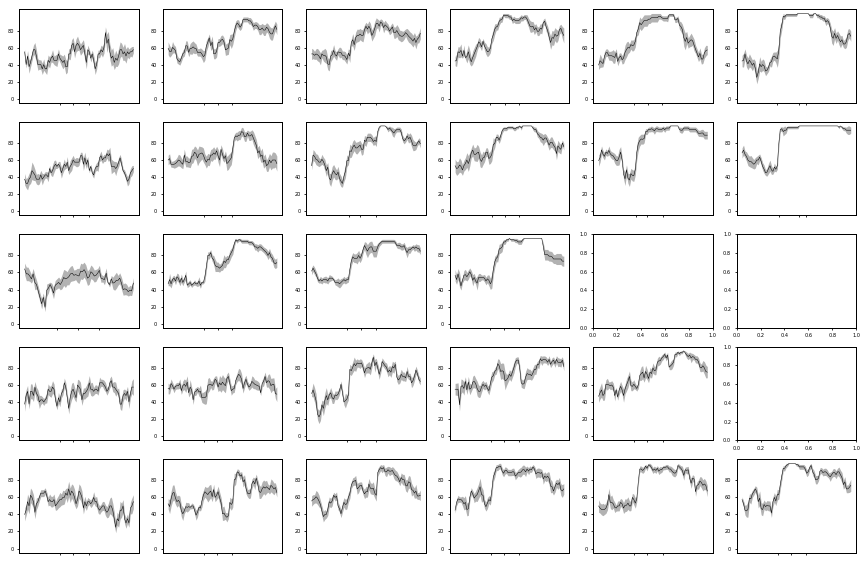

In [7]:
r, c = (len(condition.paths), 6)
f, axs = plt.subplots(r,c)
f.set_size_inches(15,10)
ylim = [-5, 105]
yticks = np.arange(0,100,20)
for i, mouse_decode_data in enumerate(all_decode_data):
    for j, (score, config) in enumerate(mouse_decode_data):
        time = np.arange(0, config.TRIAL_FRAMES) * config.TRIAL_PERIOD - config.DAQ_O_ON
        xticks = np.asarray([config.DAQ_O_ON, config.DAQ_O_OFF, config.DAQ_W_ON]) - config.DAQ_O_ON
        xticks = np.round(xticks, 1)
        pt.plot_decoding_performance(time, score, ax=axs[i,j], add_labels=False)
        axs[i,j].set_ylim(ylim)
        axs[i,j].set_yticks(yticks)
        axs[i,j].set_xticks(xticks)
        axs[i,j].set_xticklabels(['','',''])
plt.show()